In [1]:
import gym, importlib, os, sys, warnings, IPython
import tensorflow as tf
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

sys.path.append('./embodied_arch/')
import embodied_AC as em
from embodied_misc import ActionPolicyNetwork, ValueNetwork, SensoriumNetworkTemplate
importlib.reload(em)

## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

1.15.0
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/Users/oosoba/Documents/RAND/Coding/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Cartpole Benchmark Setup

In [2]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(32,), gamma_reg=1e-1)
value = lambda s: ValueNetwork(s, hSeq=(16,16,8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(st, hSeq=(16,), out_dim=out_dim, gamma_reg=5.)

In [3]:
tf.reset_default_graph()
importlib.reload(em)

env = gym.make('CartPole-v0')

num_episodes, n_epochs = (100, 601)

cpac = em.EmbodiedAgentAC(
    name="cp-emb-ac", env_=env,
    space_size = (4,1),latentDim=4,
    alpha_p=5., alpha_v=1e-2, 
    actorNN=actor, sensorium=sensor, valueNN=value,
    _every_=150
)

print(cpac, cpac.s_size, cpac.a_size)

<embodied_AC.EmbodiedAgentAC object at 0x1c392e1990> 4 1


In [4]:
saver = tf.train.Saver(max_to_keep=1)  #n_epochs = 1000
sess = tf.InteractiveSession() 
cpac.init_graph(sess)

Tensorboard logs in:  ./log/train_cp-emb-ac


In [5]:
## Verify step + play set up
state = cpac.env.reset()
print(state, cpac.act(state, sess))
# cpac.env.step(cpac.act(state, sess))

cpac.play(sess)
cpac.episode_length()

[-0.03722493  0.0104505  -0.01674799 -0.01024583] 1


11

## Baseline

In [6]:
print('Baselining untrained pnet...')
uplen0 = []
for k in range(num_episodes):
    cpac.play(sess, terminal_reward=0.)
    uplen0.append(cpac.last_total_return)
    if k%20 == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
base_perf = np.mean(uplen0)
print("\nCartpole stays up for an average of {} steps".format(base_perf))

Baselining untrained pnet...
Episode 80/100
Cartpole stays up for an average of 15.66 steps


In [7]:
st = cpac.env.reset()

## Train

	Iteration 1249: Value loss(0.6915042400360107))

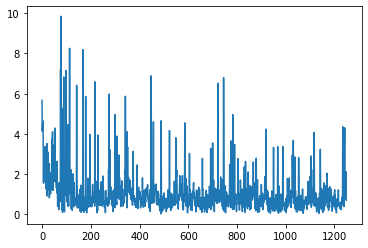

In [8]:
obs = []
for ct in range(1250):
    cpac.play(sess)
    tmp = cpac.pretrainV(sess)
    obs.append(tmp)
    print('\r\tIteration {}: Value loss({})'.format(ct, tmp), end="")
plt.plot(obs)

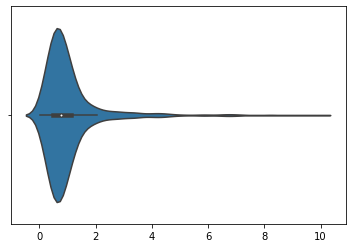

In [9]:
sns.violinplot(obs)

In [10]:
# Train pnet on cartpole episodes
print('Training...')
saver = tf.train.Saver(max_to_keep=1)
hist = cpac.work(sess, saver, num_epochs=n_epochs)

Training...
Starting agent cp-emb-ac
Epoch no.: 0/601
Step 0: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Value Fxn', 'Losses/Entropy']): ( [-1.0, -0.023739362, 0.35078445, 0.5303699] )
Saved Model
Epoch no.: 150/601
Step 150: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Value Fxn', 'Losses/Entropy']): ( [13.0, 0.05897219, 1.2869639, 0.62686294] )
Saved Model
Epoch no.: 300/601
Step 300: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Value Fxn', 'Losses/Entropy']): ( [139.0, 0.48123765, 1.9843675, 0.5843714] )
Saved Model
Epoch no.: 450/601
Step 450: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Value Fxn', 'Losses/Entropy']): ( [189.0, 0.104013234, 1.9172249, 0.5998498] )
Saved Model
Epoch no.: 600/601
Step 600: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Value Fxn', 'Losses/Entropy']): ( [189.0, 0.11262673, 1.9187517, 0.530327] )
Saved Model


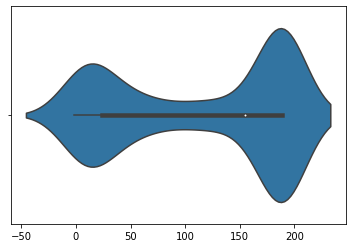

In [11]:
sns.violinplot(hist)

## Test

In [12]:
# Test pnet!
print('Testing...')
uplen = []
for k in range(num_episodes):
    cpac.play(sess, terminal_reward=0.)
    uplen.append(cpac.last_total_return)
    if k%20 == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
trained_perf = np.mean(uplen)
print("\nCartpole stays up for an average of {} steps compared to baseline {} steps".format(trained_perf, base_perf) )

Testing...
Episode 80/100
Cartpole stays up for an average of 197.85 steps compared to baseline 15.66 steps


## Evaluate

Text(0.5, 1.0, 'Trained Episode Lengths')

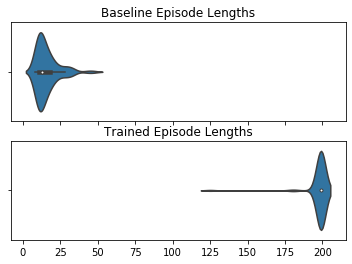

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True)
sns.violinplot(uplen0, ax = axs[0])
axs[0].set_title('Baseline Episode Lengths')
sns.violinplot(uplen, ax = axs[1])
axs[1].set_title('Trained Episode Lengths')

In [14]:
# buf = []
# last_total_return, d, s = 0, False, cpac.env.reset() 
# while (len(buf) < 1000) and not d:
#     a_t = cpac.act(s, sess) 
#     s1, r, d, *rest = cpac.env.step(a_t)
#     cpac.env.render()
#     buf.append([s, a_t, float(r), s1])
#     last_total_return += float(r)
#     s = s1
#     print("\r\tEpisode Length", len(buf), end="")

In [15]:
# sess.close()